In [2]:
!pip install axelrod

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 5.2 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from collections import deque
import axelrod as axl
from axelrod.action import Action
C, D = Action.C, Action.D

In [4]:
# Reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [5]:
# IPD Environment
class IPDEnv:
    def __init__(self, opponent, history_len=10, max_turns=100):
        self.opponent = opponent
        self.history_len = history_len
        self.max_turns = max_turns
        self.reset()

    def reset(self):
        self.agent = axl.Player()
        self.opponent.reset()
        self.agent_history = []
        self.opp_history = []
        self.turn = 0
        return self._get_state()

    def _get_state(self):
        padded_agent = [0] * (self.history_len - len(self.agent_history)) + self.agent_history[-self.history_len:]
        padded_opp = [0] * (self.history_len - len(self.opp_history)) + self.opp_history[-self.history_len:]
        return torch.tensor(padded_agent + padded_opp, dtype=torch.float32)

    def step(self, action):
        agent_action = C if action == 0 else D
        opp_action = self.opponent.strategy(self.agent)

        # Record moves in the agent's and oponnents history
        self.agent.history.append(agent_action, opp_action)
        self.opponent.history.append(opp_action, agent_action)

        # Also update the raw binary history for state vector
        self.agent_history.append(0 if agent_action == C else 1)
        self.opp_history.append(0 if opp_action == C else 1)

        payoff_matrix = {
            (C, C): (3, 3),
            (C, D): (0, 5),
            (D, C): (5, 0),
            (D, D): (1, 1)
        }

        reward, _ = payoff_matrix[(agent_action, opp_action)]
        self.turn += 1
        done = self.turn >= self.max_turns

        return self._get_state(), reward, done


In [6]:
# DQN Network and Replay Buffer
class DQN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return (
            torch.tensor(state, dtype=torch.float32),
            torch.tensor(action, dtype=torch.int64),
            torch.tensor(reward, dtype=torch.float32),
            torch.tensor(next_state, dtype=torch.float32),
            torch.tensor(done, dtype=torch.float32)
        )

    def __len__(self):
        return len(self.buffer)

In [7]:
# Training Setup
input_dim = 20
output_dim = 2
hidden_dim = 64
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.05
lr = 1e-3
batch_size = 64
num_episodes = 500

epsilon_decay = (epsilon_min / epsilon) ** (1 / (num_episodes * 0.85))
print(f"Epsilon decay: {epsilon_decay:.9f}")


policy_net = DQN(input_dim, hidden_dim, output_dim)
target_net = DQN(input_dim, hidden_dim, output_dim)
target_net.load_state_dict(policy_net.state_dict())
optimizer = optim.Adam(policy_net.parameters(), lr=lr)
replay_buffer = ReplayBuffer(10000)

def select_action(state, epsilon):
    if random.random() < epsilon:
        return random.randint(0, 1)
    with torch.no_grad():
        return policy_net(state.unsqueeze(0)).argmax().item()

Epsilon decay: 0.992976003


Episode 0,Opponent: TitFor2Tats, Reward: 295.00, Epsilon: 0.99
Episode 0, Avg Reward: 295.00, Epsilon: 0.99
Episode 1,Opponent: CyclerCCCCCD, Reward: 352.00, Epsilon: 0.99
Episode 2,Opponent: Grudger, Reward: 54.00, Epsilon: 0.98
Episode 3,Opponent: CyclerCCCCCD, Reward: 341.00, Epsilon: 0.97
Episode 4,Opponent: Grudger, Reward: 64.00, Epsilon: 0.97
Episode 5,Opponent: StochasticWSLS, Reward: 414.00, Epsilon: 0.96
Episode 6,Opponent: WinStayLoseShift, Reward: 237.00, Epsilon: 0.95
Episode 7,Opponent: WinStayLoseShift, Reward: 246.00, Epsilon: 0.95
Episode 8,Opponent: HardTitForTat, Reward: 92.00, Epsilon: 0.94
Episode 9,Opponent: Gambler, Reward: 228.00, Epsilon: 0.93
Episode 10,Opponent: FoolMeOnce, Reward: 61.00, Epsilon: 0.93
Episode 11,Opponent: StochasticWSLS, Reward: 412.00, Epsilon: 0.92
Episode 12,Opponent: CyclerCCCCCD, Reward: 345.00, Epsilon: 0.91
Episode 13,Opponent: WinStayLoseShift, Reward: 213.00, Epsilon: 0.91
Episode 14,Opponent: FoolMeOnce, Reward: 67.00, Epsilon: 0.9

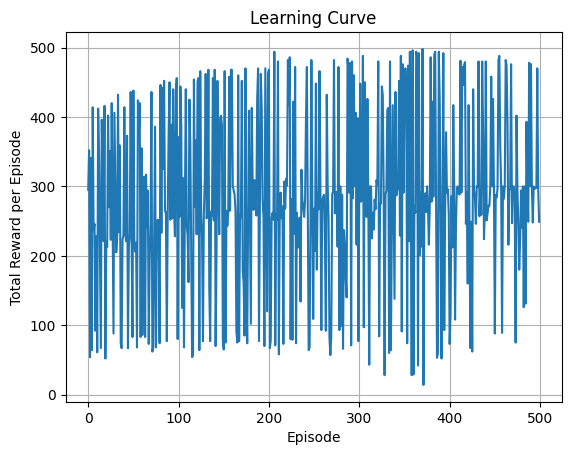

<Axes: >

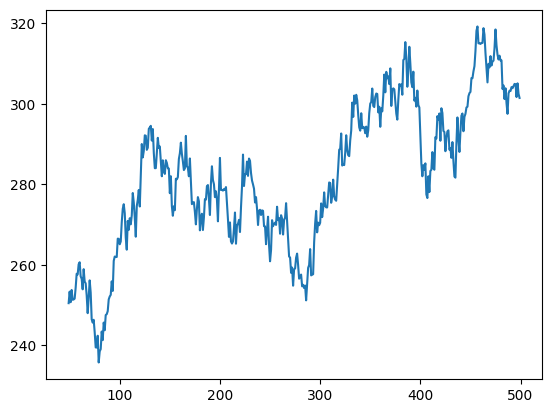

In [8]:
# Opponent pool
opponent_pool = [
    # Group 1: Exploitable & Naive
    axl.CyclerCCCCCD(),
    axl.EasyGo(),
    axl.Alternator(),

    # Group 2: Punishing/Retaliatory & Reactive
    axl.Grudger(),
    axl.ForgivingTitForTat(),
    axl.HardTitForTat(),

    # Group 3: Stochastic & Noisy
    axl.Gambler(),
    axl.SoftJoss(),
    axl.StochasticWSLS(),

    # Group 4: Deceptive & Pattern-Based
    axl.WinStayLoseShift(),
    axl.TitFor2Tats(),
    axl.FoolMeOnce()
]

# Define rewards for plotting and evaluation
Total_reward = 0
avg_rewards = []


# Best till now
for episode in range(num_episodes):
    opponent = random.choice(opponent_pool)          # 🆕 random opponent
    env = IPDEnv(opponent)                           # 🆕 new environment with that opponent
    state = env.reset()
    total_reward = 0
    done = False

    while not done:
        action = select_action(state, epsilon)
        next_state, reward, done = env.step(action)
        replay_buffer.push(state.numpy(), action, reward, next_state.numpy(), done)
        state = next_state
        total_reward += reward

        if len(replay_buffer) >= batch_size:
            s, a, r, s2, d = replay_buffer.sample(batch_size)
            q_vals = policy_net(s).gather(1, a.unsqueeze(1)).squeeze()
            next_q_vals = target_net(s2).max(1)[0]
            target = r + gamma * next_q_vals * (1 - d)
            loss = nn.MSELoss()(q_vals, target.detach())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    if episode % 10 == 0:
        target_net.load_state_dict(policy_net.state_dict())

    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    avg_rewards.append(total_reward)
    print(f"Episode {episode},Opponent: {type(opponent).__name__}, Reward: {total_reward:.2f}, Epsilon: {epsilon:.2f}")


    if episode % 100 == 0:
        print(f"Episode {episode}, Avg Reward: {total_reward:.2f}, Epsilon: {epsilon:.2f}")



torch.save(policy_net.state_dict(), "dqn_policy.pth")

# Plot reward curve
plt.plot(avg_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward per Episode")
plt.title("Learning Curve")
plt.grid(True)
plt.show()

pd.Series(avg_rewards).rolling(50).mean().plot()


In [9]:
# === RL Wrapper for Axelrod Tournament ===
import axelrod as axl
import torch
from axelrod.action import Action
import numpy as np
from collections import defaultdict
from statistics import mean

C, D = Action.C, Action.D

class RLWrapper(axl.Player):
    name = "RL Agent"

    def __init__(self, policy_net, history_len=10):
        super().__init__()
        self.policy_net = policy_net
        self.history_len = history_len

    def strategy(self, opponent):
        padded_self = [0] * (self.history_len - len(self.history)) + [
            0 if action == C else 1 for action in self.history[-self.history_len:]
        ]
        padded_opp = [0] * (self.history_len - len(opponent.history)) + [
            0 if action == C else 1 for action in opponent.history[-self.history_len:]
        ]
        state = torch.tensor(padded_self + padded_opp, dtype=torch.float32)
        with torch.no_grad():
            action_index = self.policy_net(state.unsqueeze(0)).argmax().item()
        return C if action_index == 0 else D

    def __repr__(self):
        return self.name


policy_net1 = DQN(input_dim=20, hidden_dim=64, output_dim=2)
policy_net1.load_state_dict(torch.load("dqn_policy.pth"))
policy_net1.eval()

policy_net2 = DQN(input_dim=20, hidden_dim=64, output_dim=2)
policy_net2.load_state_dict(torch.load("dqn_policy.pth"))
policy_net2.eval()

strategies = [
    axl.Defector(),
    axl.Cooperator(),
    axl.TitForTat(),
    axl.SuspiciousTitForTat(),
    RLWrapper(policy_net1),
    axl.FirstByJoss(),
    axl.StochasticCooperator(),
    axl.Calculator(),
    axl.BackStabber(),
    axl.MathConstantHunter(),
    axl.SneakyTitForTat(),
    axl.Handshake(),
    axl.CyclerCCD(),
    # Uncomment for expaned version of the tournament
    # RLWrapper(policy_net2),
    # axl.Alternator(),
    # axl.Inverse(),
    # axl.InversePunisher(),
    # axl.MetaWinnerStochastic(),
    # axl.DoubleCrosser(),
    # axl.DelayedAON1()
 ]


tournament = axl.Tournament(strategies, turns=100)
results = tournament.play()
scores_matrix = results.scores
average_scores = average_scores = [np.mean(score_row) for score_row in scores_matrix]

# Print strategies sorted by average score
print("\nΚατάταξη στρατηγικών βάσει μέσου σκορ:")
sorted_by_score = sorted(zip(results.players, average_scores), key=lambda x: -x[1])
for i, (player, score) in enumerate(sorted_by_score):
    print(f"{i+1}. {player}: {score:.2f}")




Analysing: 100%|██████████| 25/25 [00:01<00:00, 19.89it/s]


Κατάταξη στρατηγικών βάσει μέσου σκορ:
1. RL Agent: 2921.60
2. BackStabber: (D, D): 2869.80
3. Defector: 2831.60
4. Tit For Tat: 2780.10
5. Calculator: 2722.60
6. Sneaky Tit For Tat: 2715.30
7. Math Constant Hunter: 2703.20
8. Suspicious Tit For Tat: 2637.80
9. Stochastic Cooperator: 2623.50
10. Handshake: 2571.20
11. First by Joss: 0.9: 2462.90
12. Cooperator: 2266.50
13. Cycler CCD: 2143.40


In [ ]:
# Show the agent moves to be precise (log each round)
policy_net.load_state_dict(torch.load("dqn_policy.pth"))
policy_net.eval()

env = IPDEnv(axl.Defector())  # Choose opponent
state = env.reset()
done = False
round_num = 1
total_test_reward = 0

print("Round | Agent | Opponent")

while not done:
    with torch.no_grad():
        action = policy_net(state.unsqueeze(0)).argmax().item()

    next_state, reward, done = env.step(action)

    # Decode moves
    agent_move = 'C' if env.agent_history[-1] == 0 else 'D'
    opponent_move = 'C' if env.opp_history[-1] == 0 else 'D'

    print(f"{round_num:>5} |   {agent_move}   |    {opponent_move}")

    state = next_state
    round_num += 1
    total_test_reward += reward

print("Total reward:" , total_test_reward)

Round | Agent | Opponent
    1 |   C   |    D
    2 |   D   |    D
    3 |   D   |    D
    4 |   D   |    D
    5 |   C   |    D
    6 |   C   |    D
    7 |   C   |    D
    8 |   C   |    D
    9 |   D   |    D
   10 |   C   |    D
   11 |   C   |    D
   12 |   C   |    D
   13 |   C   |    D
   14 |   C   |    D
   15 |   C   |    D
   16 |   C   |    D
   17 |   C   |    D
   18 |   C   |    D
   19 |   C   |    D
   20 |   C   |    D
   21 |   C   |    D
   22 |   C   |    D
   23 |   C   |    D
   24 |   C   |    D
   25 |   C   |    D
   26 |   C   |    D
   27 |   C   |    D
   28 |   C   |    D
   29 |   C   |    D
   30 |   C   |    D
   31 |   C   |    D
   32 |   C   |    D
   33 |   C   |    D
   34 |   C   |    D
   35 |   C   |    D
   36 |   C   |    D
   37 |   C   |    D
   38 |   C   |    D
   39 |   C   |    D
   40 |   C   |    D
   41 |   C   |    D
   42 |   C   |    D
   43 |   C   |    D
   44 |   C   |    D
   45 |   C   |    D
   46 |   C   |    D
   47 |  